Import libraries

In [1]:
from google.colab import drive
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications import EfficientNetB3
import os
import seaborn as sns
import pydot
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization

Mount Drive with dataset

In [2]:
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/My Drive/AgeEstimAI/UTKFace')

Mounted at /content/gdrive


## Prepate UTKFace dataset

In [4]:
# This cell often gives an error the first time in is executed (in Colab). When executed again it works without the error.

tf.random.set_seed(8520)
random.seed(8520)

BATCH_SIZE = 32
IMG_SIZE = 200
augment_images = False

data_dir = '/content/gdrive/My Drive/AgeEstimAI/UTKFace'
all_image_paths = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir)]
random.shuffle(all_image_paths)

In [5]:
def get_label(file_path):
    age = tf.strings.split(tf.strings.split(file_path, os.sep)[-1], '_')[0]
    return tf.strings.to_number(age, tf.int32)

data_augmentation = Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomContrast(0.3),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.2),
        layers.RandomBrightness(0.3),
        layers.RandomTranslation(height_factor=0.05, width_factor=0.05),
])

# Transform image path to image, label instance for the dataset
def process_path(file_path, augment=False):
    label = get_label(file_path)
    img = tf.image.decode_jpeg(tf.io.read_file(file_path), channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    if augment:
        img = data_augmentation(img)
    return img, label

# Filter ages and extract file paths
filtered_file_paths = []
ages = []
for file_path in all_image_paths:
    age = get_label(file_path)
    if 21 <= age <= 60:
        filtered_file_paths.append(file_path)
        ages.append(age)

# Stratified split (60/20/20) -> (70/10/20)
train_files, test_files, train_ages, test_ages = train_test_split(
    filtered_file_paths, ages, test_size=0.3, random_state=3420, stratify=ages)

val_files, test_files, val_ages, test_ages = train_test_split(
    test_files, test_ages, test_size=0.66, random_state=3420, stratify=test_ages)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(train_files).map(lambda x: process_path(x, augment=False))
if augment_images:
  augmented_dataset = tf.data.Dataset.from_tensor_slices(train_files).map(lambda x: process_path(x, augment=True))
  train_dataset = train_dataset.concatenate(augmented_dataset)
val_dataset = tf.data.Dataset.from_tensor_slices(val_files).map(lambda x: process_path(x, augment=False))
test_dataset = tf.data.Dataset.from_tensor_slices(test_files).map(lambda x: process_path(x, augment=False))

# Batch and prefetch
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

Show Batch

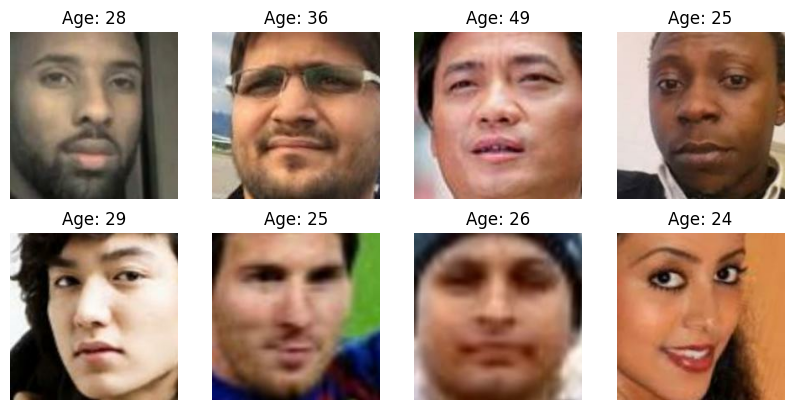

In [ ]:
import matplotlib.pyplot as plt

def show_batch(dataset, batch_size):
    """Displays a single batch of images and their labels."""
    for images, labels in dataset.take(1):
        plt.figure(figsize=(10, 10))
        for i in range(batch_size):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Age: {labels[i].numpy()}")
            plt.axis("off")
        plt.show()

show_batch(val_dataset, BATCH_SIZE)


## Training

#### Checkpoint models and early stopping

The training is stopped early after 2 epoches without improvements on the validation set. The models are saved after each improvement to have the best model in end.

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=2,
    monitor='val_loss',
    mode='min',
    verbose=1,
    restore_best_weights=True
)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

### Transformer based embedding aggregation model

In [22]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Use weights from trained model
#base_model.load_weights('best_model.h5')
base_model.load_weights('/content/gdrive/My Drive/AgeEstimAI/best_model_EffNet.h5')

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

def get_augmentation():
    data_augmentation = Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomContrast(0.3),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.2),
        layers.RandomBrightness(0.3),
        layers.RandomTranslation(height_factor=0.05, width_factor=0.05),
    ])
    return data_augmentation

# Define transformer encoder layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def transformer_encoder_stack(x, num_layers, head_size, num_heads, ff_dim, dropout=0):
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    return x

def create_final_model(num_augmentations, embedding_dim, num_encoder_layers, head_size, num_heads, ff_dim, dropout=0):
    original_inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    # Augment images
    augmentation_layer = get_augmentation()
    augmented_images = [augmentation_layer(original_inputs) for _ in range(num_augmentations)]
    stacked_augmented_images = layers.Lambda(lambda x: tf.stack(x, axis=1))(augmented_images) #Stack augmented images along new dimension

    # CNN
    cnn_model = models.Sequential([base_model, layers.GlobalAveragePooling2D()])
    embeddings = layers.TimeDistributed(cnn_model)(stacked_augmented_images)

    # Transformer Encoder Stack
    transformer_block = transformer_encoder_stack(embeddings, num_encoder_layers, head_size, num_heads, ff_dim, dropout)

    # Global Average Pooling and final Dense layer for regression
    gap = layers.GlobalAveragePooling1D()(transformer_block)
    outputs = layers.Dense(1, activation='linear')(gap)

    model = models.Model(original_inputs, outputs)

    return model

# Parameters for the transformer
num_augmentations = 8 # augmentations per image
num_encoder_layers = 6 # number of transformer encoder layers
embedding_dim = 1280 # dim of CNN output
head_size = 64
num_heads = 4
ff_dim = 64
dropout = 0.1

final_model = create_final_model(num_augmentations, embedding_dim, num_encoder_layers, head_size, num_heads, ff_dim, dropout)

#final_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.00007, decay_steps=500, decay_rate=0.75, staircase=False)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

#final_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
final_model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])

tf.keras.utils.plot_model(final_model,'model.png',show_shapes = True)
#final_model.summary()

# Train
history = final_model.fit(train_dataset, epochs=8, validation_data=val_dataset)

Epoch 1/8
362/362 [==============================] - 197s 494ms/step - loss: 5.2143 - mae: 5.6906 - val_loss: 5.4052 - val_mae: 5.8867
Epoch 2/8
362/362 [==============================] - 172s 474ms/step - loss: 4.2451 - mae: 4.7171 - val_loss: 5.3855 - val_mae: 5.8625
Epoch 3/8
362/362 [==============================] - 172s 474ms/step - loss: 4.0865 - mae: 4.5566 - val_loss: 5.1828 - val_mae: 5.6581
Epoch 4/8
362/362 [==============================] - 171s 474ms/step - loss: 3.9743 - mae: 4.4446 - val_loss: 5.1513 - val_mae: 5.6278
Epoch 5/8
362/362 [==============================] - 172s 474ms/step - loss: 3.8459 - mae: 4.3145 - val_loss: 5.1868 - val_mae: 5.6644
Epoch 6/8
362/362 [==============================] - 172s 474ms/step - loss: 3.8068 - mae: 4.2742 - val_loss: 5.2513 - val_mae: 5.7328
Epoch 7/8
362/362 [==============================] - 172s 474ms/step - loss: 3.6997 - mae: 4.1648 - val_loss: 5.2221 - val_mae: 5.7016
Epoch 8/8
362/362 [==============================] - 17

Plot training and validation loss curve

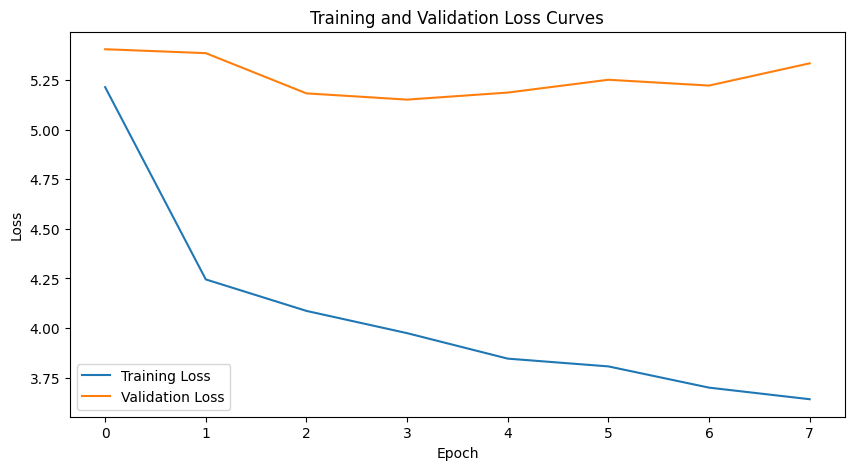

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curves')
#ax = plt.gca()
#ax.set_ylim([0, 300])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluate on test set

In [24]:
test_loss, test_mae = final_model.evaluate(test_dataset)

103/103 [==============================] - 40s 388ms/step - loss: 5.2725 - mae: 5.7486
